<a href="https://colab.research.google.com/github/amrit-thapa-2044/ICIMOD_permafrost_training_2022/blob/main/MAAT_from_ERA5_for_my_lon_lat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authenticate GEE and initiate library


In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()
#4/1AX4XfWhoutiHadZuP0Ip2eMb8hXF9kr3ynsDjtAwnHq8FO3hDYLNBAovDm8

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=38JlaxS5WNDsLGoI0nPKD0I-Rh7AaevcN3gTGETOiLs&tc=Q3MbNXvbRdgZTPXIwNsJAI-o5CIkumqkETrKhx5rDlg&cc=EgJuYK9Ip9x0RGbKDSwfiZSxNJ6bKDbR3vk8xD3pnpk

The authorization workflow will generate a code, which you should paste in the box below. 


# Define user variables

In [ ]:

# Initial date of interest (inclusive).
i_date = '1982-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# define variable of interest
my_variable='mean_2m_air_temperature' #

# Define the location of your interest as point geometry
my_lon = 81.69682
my_lat = 30.16007
my_point = ee.Geometry.Point(my_lon, my_lat)

# https://www.facebook.com/icimod/videos/993603487902353 

scale = 30000  # scale in meters


# Load image collection

In [ ]:
# Import the ERA5 image collection.
ERA5 = ee.ImageCollection('ECMWF/ERA5/DAILY')

# Load image collection

In [ ]:
# Selection of appropriate bands and dates.
ERA5_my_variable = ERA5.select(my_variable).filterDate(i_date, f_date)

# Extract value from image collection

In [ ]:
# Get the data for the pixel intersecting the our point.
ERA5_my_variable_my_point = ERA5_my_variable.getRegion(my_point, scale).getInfo()

In [ ]:
# Preview the result.
ERA5_my_variable_my_point[:5]

[['id', 'longitude', 'latitude', 'time', 'mean_2m_air_temperature'],
 ['19820101',
  81.79160661908243,
  30.048646253797994,
  378691200000,
  256.9055480957031],
 ['19820102',
  81.79160661908243,
  30.048646253797994,
  378777600000,
  256.2713317871094],
 ['19820103',
  81.79160661908243,
  30.048646253797994,
  378864000000,
  258.14593505859375],
 ['19820104',
  81.79160661908243,
  30.048646253797994,
  378950400000,
  259.2501220703125]]


# Convert result to dataframe

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
df_era5_my_point = ee_array_to_df(ERA5_my_variable_my_point,[my_variable])


# Convert Kelvin to Degree Celsius

In [ ]:
def t_era5_to_celsius(t_era5):
    """Converts era5 Kelvin to degrees Celsius."""
    t_celsius =  t_era5 - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
df_era5_my_point[my_variable] = df_era5_my_point[my_variable].apply(t_era5_to_celsius)

In [ ]:
df_era5_my_point.head()


,time,datetime,mean_2m_air_temperature
0,378691200000,1982-01-01,-16.244452
1,378777600000,1982-01-02,-16.878668
2,378864000000,1982-01-03,-15.004065
3,378950400000,1982-01-04,-13.899878
4,379036800000,1982-01-05,-15.197852


In [ ]:
df_era5_my_point.tail()


,time,datetime,mean_2m_air_temperature
13874,1577404800000,2019-12-27,-25.011328
13875,1577491200000,2019-12-28,-24.304419
13876,1577577600000,2019-12-29,-22.665396
13877,1577664000000,2019-12-30,-19.296561
13878,1577750400000,2019-12-31,-20.273657


# Restructure dataframe

In [ ]:
df_daily_final=df_era5_my_point[['datetime', 'mean_2m_air_temperature']]
df_daily_final.head()

,datetime,mean_2m_air_temperature
0,1982-01-01,-16.244452
1,1982-01-02,-16.878668
2,1982-01-03,-15.004065
3,1982-01-04,-13.899878
4,1982-01-05,-15.197852


In [ ]:
df_daily_final.set_index('datetime', inplace=True)

# Apply aggregation

In [ ]:
df_annual_mean=df_daily_final.resample('Y').mean()
df_annual_mean.head()

,mean_2m_air_temperature
datetime,
1982-12-31,-8.504696
1983-12-31,-8.907382
1984-12-31,-6.813774
1985-12-31,-7.674254
1986-12-31,-8.400355


In [ ]:
df_annual_mean.tail()

,mean_2m_air_temperature
datetime,
2015-12-31,-6.964945
2016-12-31,-5.299889
2017-12-31,-6.222358
2018-12-31,-6.568209
2019-12-31,-7.358005


# Visualize and save aggregated data (MAAT)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

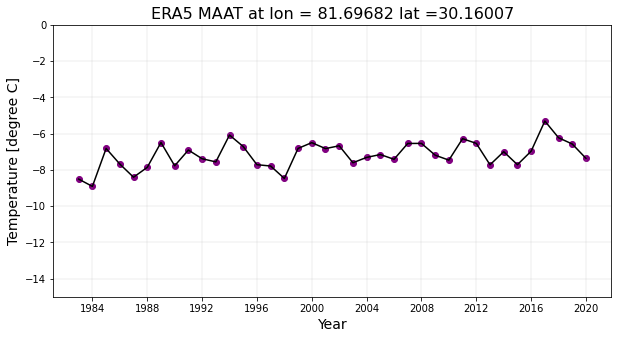

In [ ]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 5))

# Add x-axis and y-axis
ax.scatter(df_annual_mean.index.values,
           df_annual_mean['mean_2m_air_temperature'],
           color='purple')
ax.plot(df_annual_mean.index.values, df_annual_mean[my_variable],
           color='black')

ax.set_title('ERA5 MAAT at lon = '+str(my_lon)+' lat ='+str(my_lat), fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Temperature [degree C]', fontsize=14)
ax.set_ylim(-15, 0)
ax.grid(lw=0.2)

plt.savefig('ERA5_MAAT_at_lon_'+str(my_lon)+' lat_'+str(my_lat)+'.png', bbox_inches='tight',res=500)



In [ ]:
from google.colab import files
my_filename='MAAT_lon_'+str(my_lon)+'_lat_'+str(my_lat)+'_'+i_date+'_'+f_date+'.csv'
print('my file name is: ',my_filename)

df_annual_mean.to_csv(my_filename, encoding = 'utf-8-sig') 
files.download(my_filename)

my file name is:  MAAT_lon_81.69682_lat_30.16007_1982-01-01_2020-01-01.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# we can use ggplot to make plots
import plotnine
from plotnine import ggplot, aes, geom_line, ggtitle

(ggplot(data = df_annual_mean, mapping = aes(y = 'mean_2m_air_temperature')) 
+geom_line()+ggtitle('XXX'))

KeyError: ignored